In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import config_paths, explore
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, RocCurveDisplay, f1_score
from sklearn.model_selection import train_test_split

In [58]:
pd.set_option('display.max_columns', None)

In [59]:
bronze_dir = config_paths["bronze_dir"]

In [60]:
df = pd.read_csv(rf"{bronze_dir}/Data_Science_Challenge.csv")

#### Exploratory Data Analysis

In [61]:
df

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,AZ,192,415,414-4276,no,yes,36,156.2,77,26.55,215.5,126,18.32,279.1,83,12.56,9.9,6,2.67,2,False
3329,WV,68,415,370-3271,no,no,0,231.1,57,39.29,153.4,55,13.04,191.3,123,8.61,9.6,4,2.59,3,False
3330,RI,28,510,328-8230,no,no,0,180.8,109,30.74,288.8,58,24.55,191.9,91,8.64,14.1,6,3.81,2,False
3331,CT,184,510,364-6381,yes,no,0,213.8,105,36.35,159.6,84,13.57,139.2,137,6.26,5.0,10,1.35,2,False


In [62]:
explore(df)

--- Exploratory Data Analysis ---
---------------------------------
Head of DataFrame:
   state  account length  area code phone number international plan  \
0    KS             128        415     382-4657                 no   
1    OH             107        415     371-7191                 no   
2    NJ             137        415     358-1921                 no   
3    OH              84        408     375-9999                yes   
4    OK              75        415     330-6626                yes   

  voice mail plan  number vmail messages  total day minutes  total day calls  \
0             yes                     25              265.1              110   
1             yes                     26              161.6              123   
2              no                      0              243.4              114   
3              no                      0              299.4               71   
4              no                      0              166.7              113   

   total d

In [63]:
# one hot encoding for area codes
area_codes_dummies = pd.get_dummies(df["area code"], prefix="area_code", drop_first=True, dtype=int)
area_codes_dummies

,area_code_415,area_code_510
0,1,0
1,1,0
2,1,0
3,0,0
4,1,0
...,...,...
3328,1,0
3329,1,0
3330,0,1
3331,0,1


In [64]:
# convert boolean features - international plan and voice mail plan to binary values
df["international plan"] = df["international plan"].map({"yes": 1, "no": 0})
df["voice mail plan"] = df["voice mail plan"].map({"yes": 1, "no": 0})

In [65]:
# dropping phone number and state columns as they are not useful for the model
# dropping area code as we have already one hot encoded it
df = df.drop(columns=["phone number", "state", "area code"])

# concatenate the one hot encoded area codes
df = pd.concat([df, area_codes_dummies], axis=1)

In [66]:
df

,account length,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn,area_code_415,area_code_510
0,128,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False,1,0
1,107,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False,1,0
2,137,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False,1,0
3,84,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False,0,0
4,75,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,192,0,1,36,156.2,77,26.55,215.5,126,18.32,279.1,83,12.56,9.9,6,2.67,2,False,1,0
3329,68,0,0,0,231.1,57,39.29,153.4,55,13.04,191.3,123,8.61,9.6,4,2.59,3,False,1,0
3330,28,0,0,0,180.8,109,30.74,288.8,58,24.55,191.9,91,8.64,14.1,6,3.81,2,False,0,1
3331,184,1,0,0,213.8,105,36.35,159.6,84,13.57,139.2,137,6.26,5.0,10,1.35,2,False,0,1


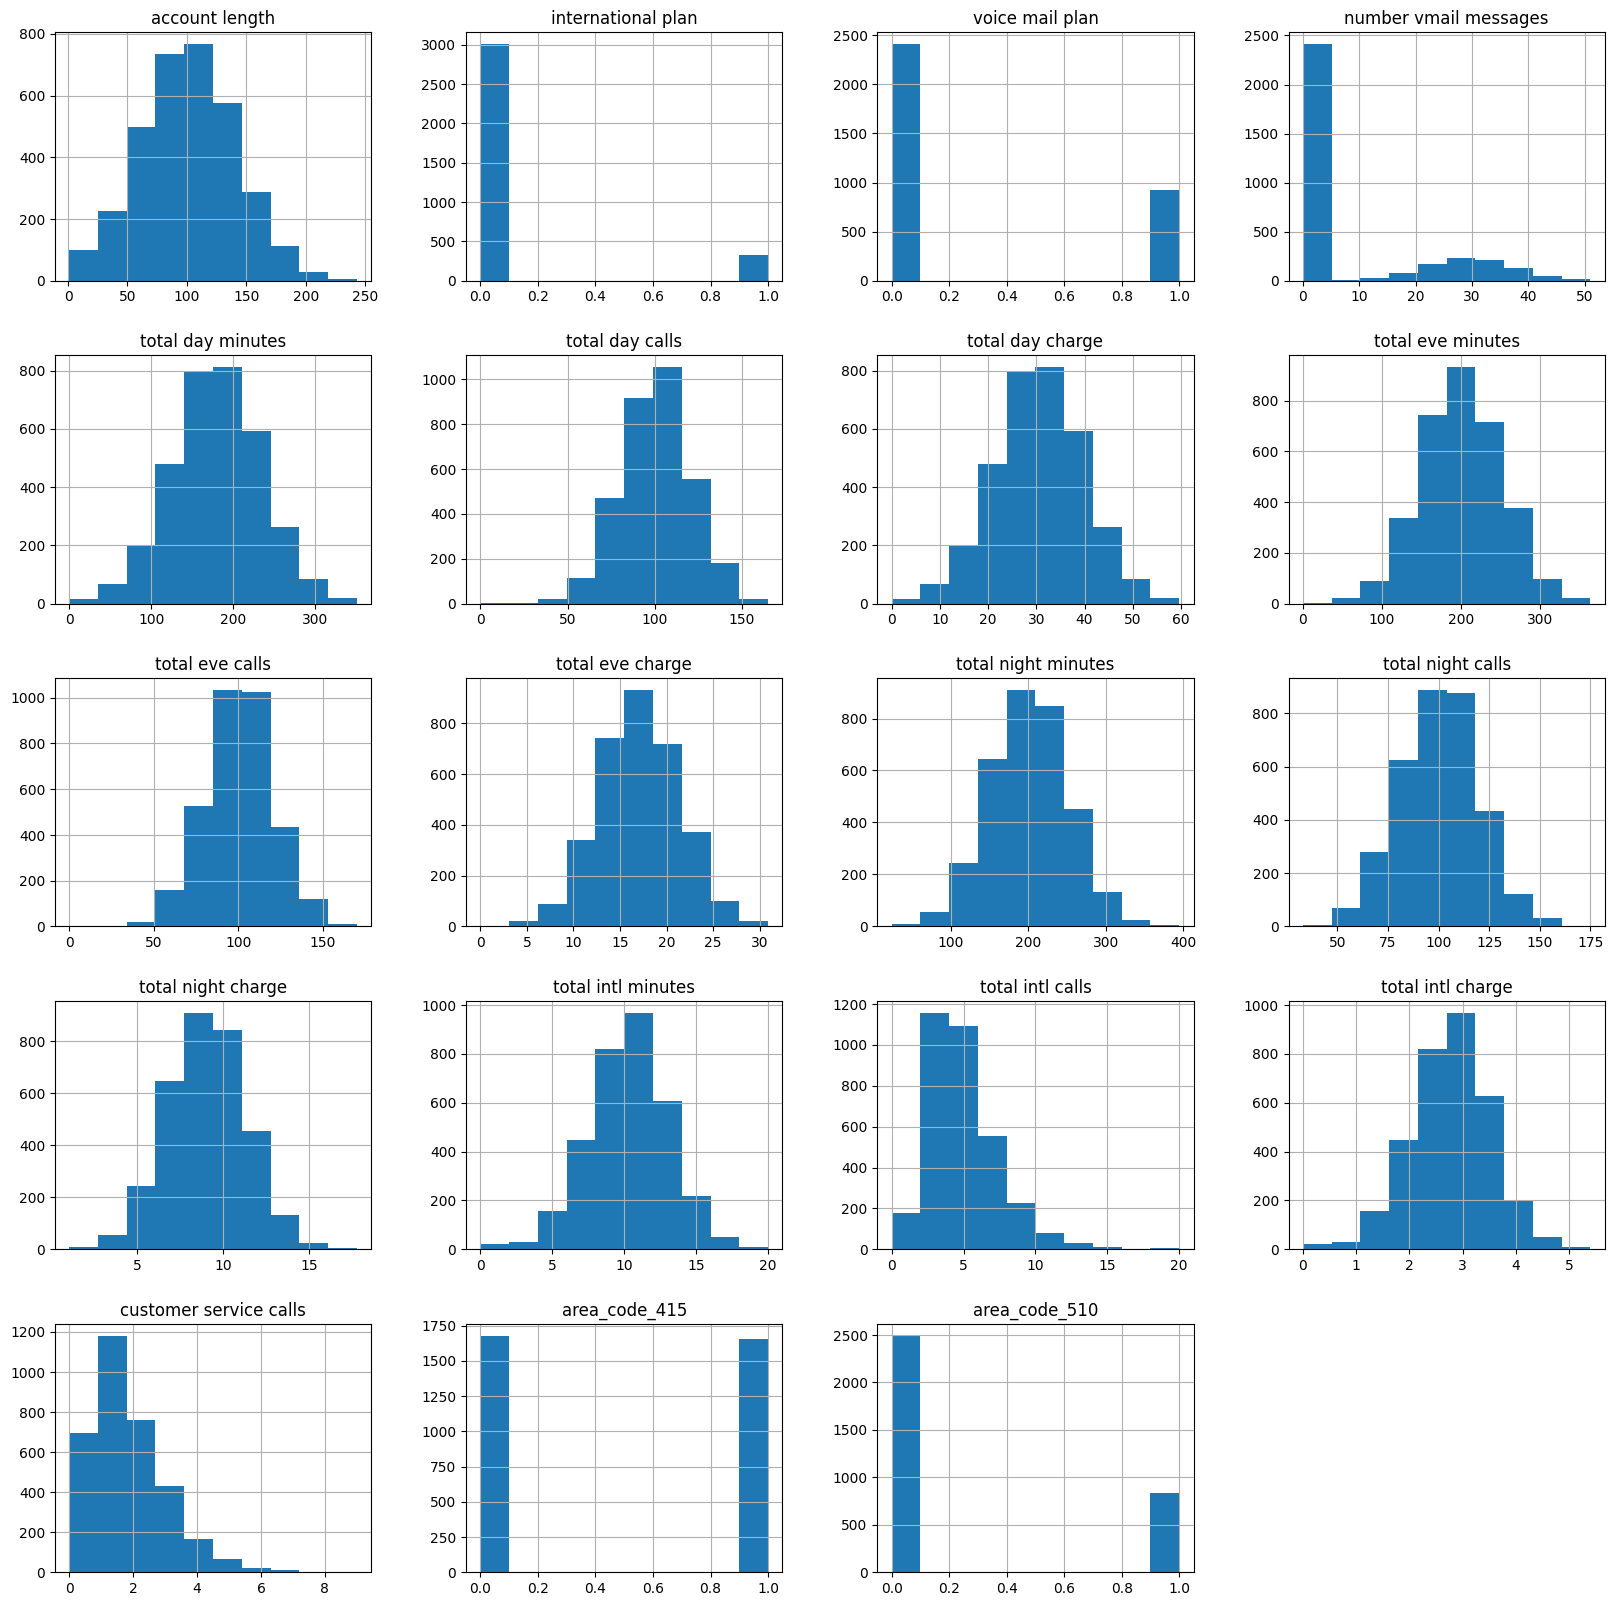

In [67]:
# histogram of each feature to explore distribution
df.hist(figsize=(20, 20))

plt.show()

1. Total day minutes, total evening minutes and total night minutes have similar distribution yet total day charge has rightward distribution relative to total evening charge which has rightward distribution relative to total night charge - Company charges more per minute for day time calls compared to evening and more for evening calls than night time calls. Consequently, company makes more money from day time calls.
2. Most consumers in dataset don't have either international plan or voice mail plan. This obviously also correlates with most consumers having 0 voice mail messages

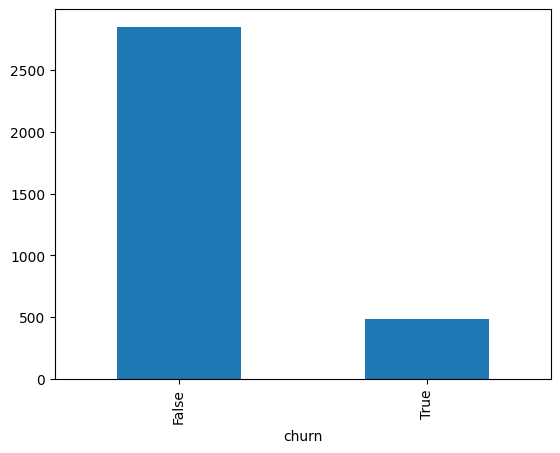

In [68]:
# Distribution of churn
df["churn"].value_counts().plot(kind="bar")
plt.show()

This is an imbalanced dataset which means metrics coming out of classifier predictions should be carefully evaluated

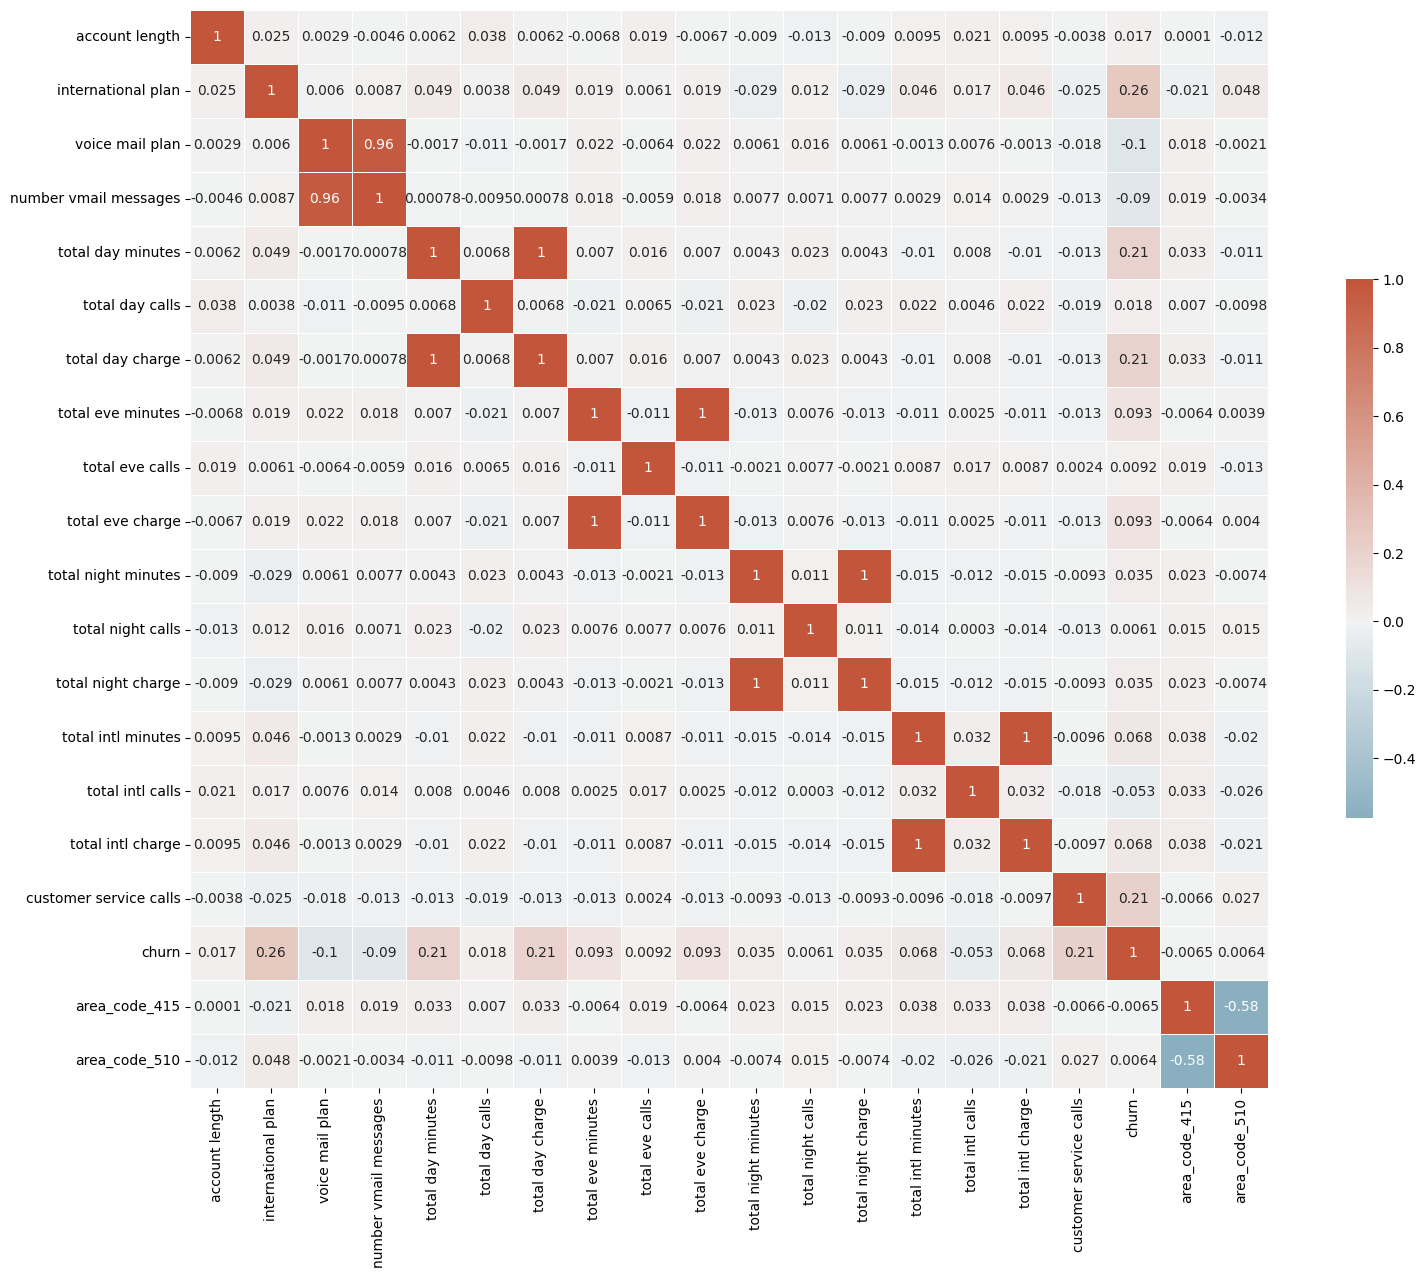

In [69]:
# explore correlation between features
plt.figure(figsize=(20, 14))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(df.corr(), annot=True, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

In [70]:
X = df.drop(columns=["churn"])
y = df["churn"]

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [71]:
# scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [72]:
knn_model = KNeighborsClassifier(n_neighbors=1)
knn_model.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=1)

In [73]:
y_pred = knn_model.predict(X_test_scaled)

In [74]:
tp = np.sum((y_pred == y_test) & (y_test == 1))
tn = np.sum((y_pred == y_test) & (y_test == 0))
fp = np.sum((y_pred != y_test) & (y_test == 0))
fn = np.sum((y_pred != y_test) & (y_test == 1))

In [75]:
tp, tn, fp, fn

(np.int64(43), np.int64(528), np.int64(38), np.int64(58))

In [76]:
accuracy = (tp + tn) / (tp + tn + fp + fn)
accuracy

np.float64(0.856071964017991)

In [77]:
confusion_matrix(y_test, y_pred)

array([[528,  38],
       [ 58,  43]])

In [78]:
# compute accuracy score
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.856071964017991

In [79]:
recall = tp / (tp + fn)
precision = tp / (tp + fp)
precision, recall

(np.float64(0.5308641975308642), np.float64(0.42574257425742573))

In [80]:
f1 = 2 * (precision * recall) / (precision + recall)
f1

np.float64(0.47252747252747246)

In [81]:
f1_score(y_test, y_pred, average="macro")

0.6945970695970696

In [82]:
precision_0 = np.sum((y_pred == y_test) & (y_test == 0)) / np.sum(y_pred == 0)
recall_0 = np.sum((y_pred == y_test) & (y_test == 0)) / np.sum(y_test == 0)
precision_0, recall_0

(np.float64(0.9010238907849829), np.float64(0.9328621908127208))

In [83]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.90      0.93      0.92       566
        True       0.53      0.43      0.47       101

    accuracy                           0.86       667
   macro avg       0.72      0.68      0.69       667
weighted avg       0.84      0.86      0.85       667



In [84]:
# elbow method for finding the best k value - use both accuracy and f1 score considering this is an imbalanced dataset
test_errors = []
for k in range(1, 31):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train_scaled, y_train)
    y_pred = knn_model.predict(X_test_scaled)
    test_errors.append({
        "k": k,
        "error": 1 - accuracy_score(y_test, y_pred),
        "accuracy": accuracy_score(y_test, y_pred),
        "f1_score": f1_score(y_test, y_pred, average="macro")
    })

In [85]:
# find the best k value based on accuracy and f1 score
best_k_accuracy = max(test_errors, key=lambda x: x["accuracy"])
best_k_f1 = max(test_errors, key=lambda x: x["f1_score"])
best_k_accuracy, best_k_f1

({'k': 3,
  'error': 0.10944527736131937,
  'accuracy': 0.8905547226386806,
  'f1_score': 0.7305318966423713},
 {'k': 3,
  'error': 0.10944527736131937,
  'accuracy': 0.8905547226386806,
  'f1_score': 0.7305318966423713})

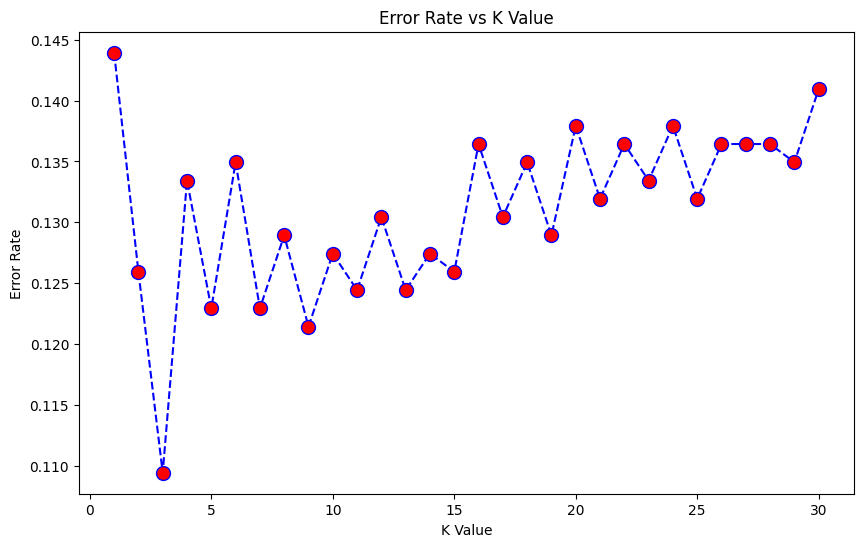

In [86]:
# plot the error rate for different k values
plt.figure(figsize=(10, 6))
plt.plot([x["k"] for x in test_errors], [x["error"] for x in test_errors], color="blue", linestyle="dashed", marker="o",
         markerfacecolor="red", markersize=10)
plt.title("Error Rate vs K Value")
plt.xlabel("K Value")
plt.ylabel("Error Rate")
plt.show()